# Stroke Prediction - Modeling

## Capstone Project 1 - Brooke Hanson

### Introduction

### 1: The Problem 

This data was recorded in order for hospitals and healthcare practitioners to better understand the factors that most influence stroke occurance. The goal is to create a predictive model that will determine whether or not new patients will experience a stroke. This is a classification problem.

### 2: The Data

The Kaggle hosts the original problem and the dataset in their website as one of their competitions. Here, I downloaded the data from the Kaggle website. Following are the data fields in the dataset, which we are going to read in the Pandas data frame.

- id 
- gender             
- age                
- hypertension         
- heart_disease        
- ever_married        
- work_type           
- Residence_type     
- avg_glucose_level  
- bmi                
- smoking_status      
- stroke

### Importing Necessary Packages & Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency as chi2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.preprocessing import scale

In [13]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [14]:
# filling NA in BMI
# df['bmi'] = df['bmi'].replace(np.nan ,np.median(df['bmi'])) 
median_value = 28.1 # can see from info table that the median for bmi is 28.1
df['bmi'].fillna(value=median_value, inplace=True)

In [15]:
df['gender'] = df['gender'].replace('Other', 'Female')

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.862035,7.699562,10.30,23.800,28.100,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


### Testing and Making Model

In [17]:
df['hypertension'] = df['hypertension'].replace({0 : 'No', 1 : 'Yes'})
df['heart_disease'] = df['heart_disease'].replace({0: 'No', 1 : 'Yes'})
df = df[['age', 'hypertension','heart_disease', 'avg_glucose_level','bmi','stroke','gender','ever_married','work_type','Residence_type','smoking_status']]

#### Making Dummy Variables

In [18]:
df1 = pd.get_dummies(df, drop_first = True) 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   avg_glucose_level               5110 non-null   float64
 2   bmi                             5110 non-null   float64
 3   stroke                          5110 non-null   int64  
 4   hypertension_Yes                5110 non-null   uint8  
 5   heart_disease_Yes               5110 non-null   uint8  
 6   gender_Male                     5110 non-null   uint8  
 7   ever_married_Yes                5110 non-null   uint8  
 8   work_type_Never_worked          5110 non-null   uint8  
 9   work_type_Private               5110 non-null   uint8  
 10  work_type_Self-employed         5110 non-null   uint8  
 11  work_type_children              5110 non-null   uint8  
 12  Residence_type_Urban            51

### Testing best Split size

In [19]:
X = df1.drop('stroke', axis = 1)
y = df1.stroke

In [22]:
size = [0.1, 0.2, 0.25, 0.3, 0.33, 0.35]

for i in size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=1)
    # fit the model
    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    # make predictions
    y_pred = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy: %.3f' % acc)

Accuracy: 0.961
Accuracy: 0.940
Accuracy: 0.940
Accuracy: 0.946
Accuracy: 0.946
Accuracy: 0.946


In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [24]:
X_train.shape, y_train.shape

((4599, 15), (4599,))

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 346 to 860
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4599 non-null   float64
 1   avg_glucose_level               4599 non-null   float64
 2   bmi                             4599 non-null   float64
 3   hypertension_Yes                4599 non-null   uint8  
 4   heart_disease_Yes               4599 non-null   uint8  
 5   gender_Male                     4599 non-null   uint8  
 6   ever_married_Yes                4599 non-null   uint8  
 7   work_type_Never_worked          4599 non-null   uint8  
 8   work_type_Private               4599 non-null   uint8  
 9   work_type_Self-employed         4599 non-null   uint8  
 10  work_type_children              4599 non-null   uint8  
 11  Residence_type_Urban            4599 non-null   uint8  
 12  smoking_status_formerly smoked  4

### Decision Tree Model

In [26]:
clf = DecisionTreeClassifier(class_weight = 'balanced',random_state=0)
clf.fit(X_train ,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [27]:
pred_test = clf.predict(X_test)

In [28]:
confusion_matrix(pred_test, y_test)

array([[464,  27],
       [ 19,   1]])

In [29]:
list(zip(clf.feature_importances_,X_test.columns))

[(0.4463323129200995, 'age'),
 (0.2229252678575099, 'avg_glucose_level'),
 (0.16679252610196643, 'bmi'),
 (0.024725569847581837, 'hypertension_Yes'),
 (0.020822312031021875, 'heart_disease_Yes'),
 (0.02128329584366639, 'gender_Male'),
 (0.01886342615089682, 'ever_married_Yes'),
 (0.0, 'work_type_Never_worked'),
 (0.01606889440903949, 'work_type_Private'),
 (0.016290247595345614, 'work_type_Self-employed'),
 (0.0, 'work_type_children'),
 (0.006415820967935133, 'Residence_type_Urban'),
 (0.019046690431450936, 'smoking_status_formerly smoked'),
 (0.010483116744207927, 'smoking_status_never smoked'),
 (0.009950519099278275, 'smoking_status_smokes')]

Feature: 0, Score: 0.44633
Feature: 1, Score: 0.22293
Feature: 2, Score: 0.16679
Feature: 3, Score: 0.02473
Feature: 4, Score: 0.02082
Feature: 5, Score: 0.02128
Feature: 6, Score: 0.01886
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.01607
Feature: 9, Score: 0.01629
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00642
Feature: 12, Score: 0.01905
Feature: 13, Score: 0.01048
Feature: 14, Score: 0.00995


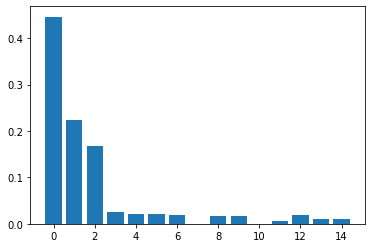

In [30]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [31]:
cv_scores_test= cross_val_score(clf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(clf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_dt_test= cv_scores_test.mean()
cv_scores_dt_train= cv_scores_train.mean()
cv_scores_std_dt= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_dt_test))
print ('Mean cross validation train score: ' +str(cv_scores_dt_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_dt))

[0.53178694 0.5742268  0.5742268  0.48958333 0.5625    ]
Mean cross validation test score: 0.5464647766323024
Mean cross validation train score: 0.5391835181561209
Standard deviation in cv scores: 0.032402241165986286


In [33]:
cnf_matrix = confusion_matrix(y_test, pred_test)
print(cnf_matrix)
Accuracy_dt=clf.score(X_test,y_test)
print(Accuracy_dt)

[[464  19]
 [ 27   1]]
0.9099804305283757


### K Nearest Neighbor

In [35]:
# normalize any other non categorical variables, can standardize by max and min
# look at hyper parameters in grid search
# see performance decrease with overfitting
# for each model i chose find optimal hyperparameter
# and explain meaning of hyperparameter i chose but not too many 
# for decision start with max depth
# for random forest do 20 50 80 scale for optimizing

# not scaled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

print(nca_pipe.score(X_test, y_test))

0.9295499021526419


In [36]:
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(Xs_train, y_train)

print(nca_pipe.score(Xs_test, y_test))

0.9334637964774951


In [37]:
from sklearn.model_selection import cross_val_score
#unscaled train test
cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.59415064 0.64503205 0.63389757 0.79882812 0.64822049]
Mean cross validation test score: 0.6640257745726496
Mean cross validation train score: 0.5893343726942689
Standard deviation in cv scores: 0.07010347406653955


In [38]:
#scaled train test
cv_scores_test= cross_val_score(knn,Xs_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,Xs_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.44391026 0.49719551 0.60438368 0.44010417 0.57986111]
Mean cross validation test score: 0.5130909455128204
Mean cross validation train score: 0.5617217988437411
Standard deviation in cv scores: 0.06805633092831971


In [40]:
#cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
Accuracy_knn=knn.score(X_test,y_test)
print(Accuracy_knn)

0.9393346379647749


### Random Forrest

In [41]:
# recall
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
rc = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Recall=%.3f' % (rc))

print('Random Forest: f1-score=%.3f' % (f1))

print(cm)

Random Forest: Recall=0.000
Random Forest: f1-score=0.910
[[960   0]
 [ 62   0]]


In [42]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy_rf=clf.score(X_test,y_test)
print(Accuracy_rf)

[[960   0]
 [ 62   0]]
0.9393346379647749


In [43]:
list(zip(clf.feature_importances_,X_test.columns))
#X_test.shape

[(0.24811996079858667, 'age'),
 (0.2740759567924639, 'avg_glucose_level'),
 (0.23467593896247133, 'bmi'),
 (0.026413487706809034, 'hypertension_Yes'),
 (0.024411704388851773, 'heart_disease_Yes'),
 (0.03289472516240092, 'gender_Male'),
 (0.018795183841477183, 'ever_married_Yes'),
 (2.950613074750369e-05, 'work_type_Never_worked'),
 (0.02425354389862407, 'work_type_Private'),
 (0.018197737528560725, 'work_type_Self-employed'),
 (0.0013973408667473989, 'work_type_children'),
 (0.032498807440159094, 'Residence_type_Urban'),
 (0.019492646402351124, 'smoking_status_formerly smoked'),
 (0.025241099015619328, 'smoking_status_never smoked'),
 (0.019502361064129954, 'smoking_status_smokes')]

Feature: 0, Score: 0.24812
Feature: 1, Score: 0.27408
Feature: 2, Score: 0.23468
Feature: 3, Score: 0.02641
Feature: 4, Score: 0.02441
Feature: 5, Score: 0.03289
Feature: 6, Score: 0.01880
Feature: 7, Score: 0.00003
Feature: 8, Score: 0.02425
Feature: 9, Score: 0.01820
Feature: 10, Score: 0.00140
Feature: 11, Score: 0.03250
Feature: 12, Score: 0.01949
Feature: 13, Score: 0.02524
Feature: 14, Score: 0.01950


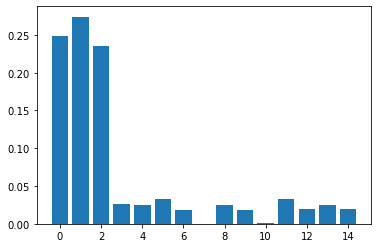

In [44]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [45]:
cv_scores_test= cross_val_score(clf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(clf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.82071314 0.72576122 0.74327257 0.85503472 0.84570312]
Mean cross validation test score: 0.7980969551282051
Mean cross validation train score: 0.8012109779641285
Standard deviation in cv scores: 0.05340022609495899


### Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score

In [47]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1022 points : 464


In [48]:
y_pred = gnb.fit(Xs_train, y_train).predict(Xs_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (Xs_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1022 points : 717


In [49]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy_nb=gnb.score(X_test,y_test)
print(Accuracy_nb)

[[243 717]
 [  0  62]]
0.9393346379647749


In [50]:
# unscaled data
cv_scores_test= cross_val_score(gnb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gnb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.7588141  0.76362179 0.78385417 0.88975694 0.88237847]
Mean cross validation test score: 0.815685096153846
Mean cross validation train score: 0.8020038685494579
Standard deviation in cv scores: 0.05812529646353869


In [51]:
#scaled data
cv_scores_test= cross_val_score(gnb,Xs_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gnb,Xs_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.7588141  0.76362179 0.78385417 0.88975694 0.88237847]
Mean cross validation test score: 0.815685096153846
Mean cross validation train score: 0.8020038685494579
Standard deviation in cv scores: 0.05812529646353869


### Model Comparison

In [52]:
myLabels = [ 'Decision Tree','KNN','Random Forest', 'Naive Bayes']
score_test= [ cv_scores_dt_test, cv_scores_knn_test,cv_scores_rf_test,cv_scores_nb_test]
score_train= [  cv_scores_dt_train,cv_scores_knn_train,cv_scores_rf_train,cv_scores_nb_train]
Accuracy_score = [Accuracy_dt,Accuracy_knn,Accuracy_rf,Accuracy_nb]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

       Algorithm  Model accuracy score
0  Decision Tree              0.909980
1            KNN              0.939335
2  Random Forest              0.939335
3    Naive Bayes              0.939335


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Decision Tree,0.539184,0.546465
1,KNN,0.561722,0.513091
2,Random Forest,0.801211,0.798097
3,Naive Bayes,0.802004,0.815685


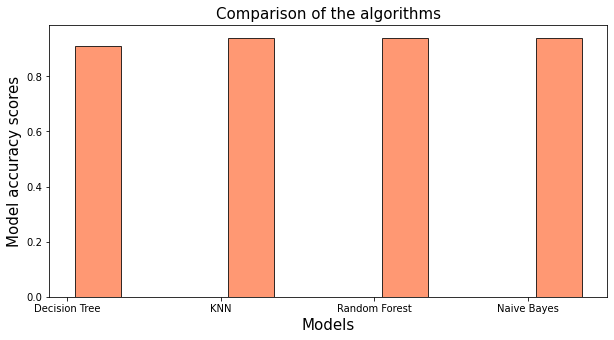

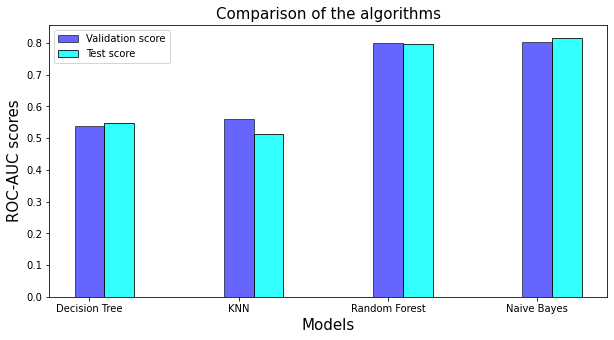

In [53]:
#plotting the accuracy scores:


index=[1,2,3,4]
index_acc=[1.2,2.2,3.2,4.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3,4], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()

#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4]
index_acc=[1.2,2.2,3.2,4.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Validation score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

Hyperparameter tuning for Random Forrest




0.9547455315988708
In [129]:


0.2984344422700587
0.8115217681623932
In [131]:


​

                          Features  Importance scores
0                              age           0.000120
1                avg_glucose_level           0.005540
2                              bmi           0.016601
3                 hypertension_Yes           0.018525
4                heart_disease_Yes           0.019848
5                      gender_Male           0.023020
6                 ever_married_Yes           0.023437
7           work_type_Never_worked           0.024335
8                work_type_Private           0.024635
9          work_type_Self-employed           0.027808
10              work_type_children           0.028696
11            Residence_type_Urban           0.028973
12  smoking_status_formerly smoked           0.212069
13     smoking_status_never smoked           0.244802
14           smoking_status_smokes           0.301589

In [132]:


ROC-AUC Score: 0.8432963709677419
In [133]:



Compare tuned Random Forrest to Naive Bayes
In [134]:


[0.80909455 0.75220353 0.79340278 0.859375   0.84353299]
Mean cross validation test score: 0.8115217681623932
Mean cross validation train score: 0.7800519277669018
Standard deviation in cv scores: 0.03786157144659964
In [135]:


​
score_tab
       Algorithm  Model accuracy score
0  Random Forest              0.939335
1    Naive Bayes              0.939335
Out[135]:
Algorithm	ROC-AUC train score	ROC-AUC test score
0	Random Forest	0.780052	0.811522
1	Naive Bayes	0.802004	0.815685
In [137]:

​

​
#plotting and comparing ROC-AUC train/test scores:
​



Conclusions
In order to effectively predict stroke occurance, I looked at 14 features to most accurately predict, with the most important features being age, bmi, and avg glucose level.
This is a classification problem and used below models to identify accurate predictions
Random Forrest Classifier
Naive Bayes
Decision Tree
K-Nearest Neighbor
On initial testing it seemed Naive Bayes was the most accurate model, after tuning the Random Forrest model, I found their accurate prediction power was comperable.
The data was split into a test size of 0.30, and a training set of 0.7, this was decided by comparing accuracy of multiple test sizes finding 0.3 was the size that yielded best results.
After tuning the Random Forrest model, the model accuracy for both the Naive Bayes and Random Forrest both had scores of 0.939355
Improvements
There is room for improvement in the data, there were 5110 patients yet there is room for more data. More classification algorithms could be used to compare and determine if there is a model with more predictive power. Some features with less importance could be removed to determine if that effects the predicting power.

In [54]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=1)
0.9547455315988708


In [55]:
RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=1)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=1)

In [56]:
rf = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
y_predictions_rf = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cv = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
print(acc)
print(cv)

0.2984344422700587
0.8115217681623932


In [58]:
#Feature importances:

features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

                          Features  Importance scores
0                              age           0.000120
1                avg_glucose_level           0.005540
2                              bmi           0.016601
3                 hypertension_Yes           0.018525
4                heart_disease_Yes           0.019848
5                      gender_Male           0.023020
6                 ever_married_Yes           0.023437
7           work_type_Never_worked           0.024335
8                work_type_Private           0.024635
9          work_type_Self-employed           0.027808
10              work_type_children           0.028696
11            Residence_type_Urban           0.028973
12  smoking_status_formerly smoked           0.212069
13     smoking_status_never smoked           0.244802
14           smoking_status_smokes           0.301589


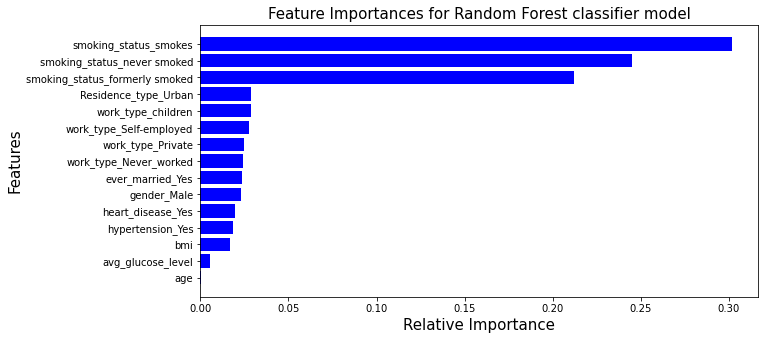

In [59]:
#Visual comparison:
plt.figure(figsize=(10,5))
#indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.savefig("28.png")
plt.show()
#len(importances)

In [60]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8432963709677419


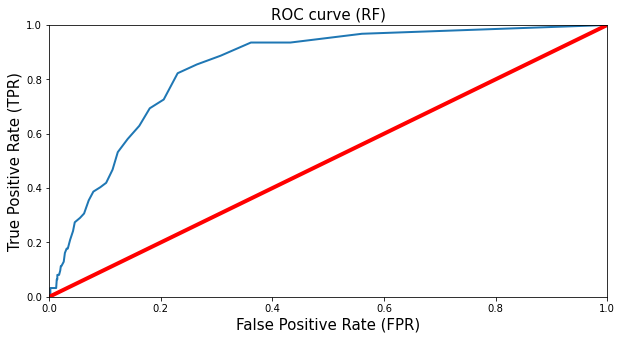

In [61]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

### Compare Tuned Random Forrest To Naive Bayes

In [62]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.80909455 0.75220353 0.79340278 0.859375   0.84353299]
Mean cross validation test score: 0.8115217681623932
Mean cross validation train score: 0.7800519277669018
Standard deviation in cv scores: 0.03786157144659964


In [63]:
myLabels = [ 'Random Forest', 'Naive Bayes']
score_test= [ cv_scores_rf_test,cv_scores_nb_test]
score_train= [  cv_scores_rf_train,cv_scores_nb_train]
Accuracy_score = [Accuracy_rf,Accuracy_nb]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

       Algorithm  Model accuracy score
0  Random Forest              0.939335
1    Naive Bayes              0.939335


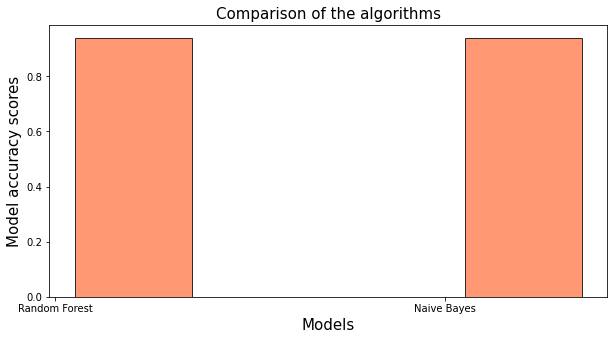

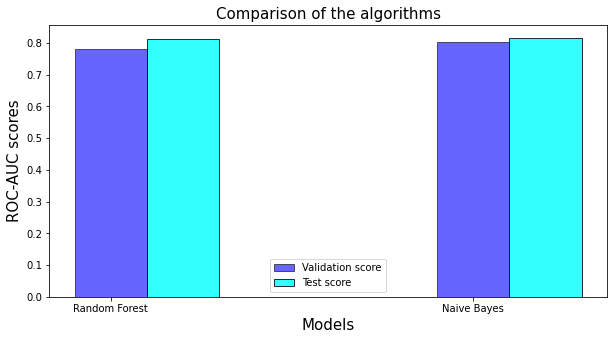

In [64]:
index=[1,2]
index_acc=[1.2,2.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()


index=[1,2]
index_acc=[1.2,2.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Validation score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

### Conclusions
In order to effectively predict stroke occurance, I looked at 14 features to most accurately predict, with the most important features being age, bmi, and avg glucose level.
This is a classification problem and used below models to identify accurate predictions
Random Forrest Classifier
Naive Bayes
Decision Tree
K-Nearest Neighbor
On initial testing it seemed Naive Bayes was the most accurate model, after tuning the Random Forrest model, I found their accurate prediction power was comperable.
The data was split into a test size of 0.30, and a training set of 0.7, this was decided by comparing accuracy of multiple test sizes finding 0.3 was the size that yielded best results.
After tuning the Random Forrest model, the model accuracy for both the Naive Bayes and Random Forrest both had scores of 0.939355


### Improvements
There is room for improvement in the data, there were 5110 patients yet there is room for more data. More classification algorithms could be used to compare and determine if there is a model with more predictive power. Some features with less importance could be removed to determine if that effects the predicting power.